In [201]:
# Core Python Libraries
import os  # Operating system interactions, such as reading and writing files.
import shutil  # High-level file operations like copying and moving files.
import random  # Random number generation for various tasks.
import textwrap  # Formatting text into paragraphs of a specified width.
import warnings  # Warning control context manager.
import zipfile  # Work with ZIP archives.
import platform  # Access to underlying platform’s identifying data.
import itertools  # Functions creating iterators for efficient looping.
from dataclasses import dataclass  # Class decorator for adding special methods to classes.

# PyTorch-related Libraries (Deep Learning)
import torch  # Core PyTorch library for tensor computations.
import torch.nn as nn  # Neural network module for defining layers and architectures.
from torch.nn import functional as F  # Functional module for defining functions and loss functions.
import torch.optim as optim  # Optimizer module for training models (SGD, Adam, etc.).
from torch.utils.data import Dataset, DataLoader, Subset, random_split  # Dataset and DataLoader for managing and batching data.
import torchvision # PyTorch's computer vision library.
from torchvision import datasets, transforms  # Datasets and transformations for image processing.
import torchvision.datasets as datasets  # Datasets for computer vision tasks.
import torchvision.transforms as transforms  # Transformations for image preprocessing.
from torchvision.utils import make_grid  # Make grid for displaying images.
import torchvision.models as models  # Pretrained models for transfer learning.
from torchvision.datasets import MNIST, EuroSAT  # MNIST and EuroSAT datasets for image classification.
import torchvision.transforms.functional as TF  # Functional transformations for image preprocessing.
from torchsummary import summary # PyTorch model summary for Keras-like model summary.
import torchsummary
import torchmetrics
from torchviz import make_dot  # PyTorch model visualization.
from torchvision.ops import sigmoid_focal_loss  # Focal loss for handling class imbalance in object detection.
from torchmetrics import MeanMetric, Accuracy  # Intersection over Union (IoU) metric for object detection.
from torchmetrics.classification import MulticlassF1Score, MulticlassRecall, MulticlassPrecision, MulticlassAccuracy  # Multilabel classification metrics.
from torchvision.models import ResNet18_Weights  # ResNet-18 model with pretrained weights.
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask  # Overlay mask on image for visualization.


import pytorch_lightning as pl  # PyTorch Lightning for high-level training loops.
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, Callback # Callbacks for model checkpointing and learning rate monitoring.
from pytorch_lightning.loggers import TensorBoardLogger  # Logger for TensorBoard visualization.

# Geospatial Data Processing Libraries
import rasterio  # Library for reading and writing geospatial raster data.
from rasterio.warp import calculate_default_transform, reproject  # Reprojection and transformation functions.
from rasterio.enums import Resampling  # Resampling methods used for resizing raster data.
from rasterio.plot import show  # Visualization of raster data.

# Data Manipulation and Analysis Libraries
import pandas as pd  # Data analysis and manipulation library for DataFrames and CSVs.
import numpy as np  # Numpy for array operations and numerical computations.
from sklearn.metrics import confusion_matrix, accuracy_score  # Evaluation metrics for classification models.

# Visualization Libraries
import matplotlib.pyplot as plt  # Plotting library for creating static and interactive visualizations.
import seaborn as sns  # High-level interface for drawing attractive statistical graphics.

# Utilities
from tqdm import tqdm  # Progress bar for loops and processes.
from PIL import Image  # Image handling, opening, manipulating, and saving.
import ast  # Abstract Syntax Trees for parsing Python code.
import requests  # HTTP library for sending requests.
import zstandard as zstd  # Zstandard compression for fast compression and decompression.
from collections import Counter # Counter for counting hashable objects.
import certifi  # Certificates for verifying HTTPS requests.
import ssl  # Secure Sockets Layer for secure connections.
import urllib.request  # URL handling for requests.
import kaggle # Kaggle API for downloading datasets.
import zipfile # Work with ZIP archives.
from IPython.display import Image # Display images in Jupyter notebooks.


In [202]:
# Set seed for reproducibility
# Setting a seed ensures that the results are consistent and reproducible each time the code is run.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Check if GPU is enabled
# PyTorch allows for the use of GPU to speed up training. Here we check if a GPU is available and set the device accordingly.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == 'cuda':
    # If a GPU is available, print the name of the GPU
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Device: cuda:0
GPU: NVIDIA GeForce RTX 3050


In [203]:
@dataclass
class Config:
    dataset_path = r'C:\Users\isaac\eurosat_small'
    imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    batch_size = 64
    num_workers = 4
    num_classes = 10
    model_name = 'resnet18'

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])
    
    test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

In [204]:
class EuroSATDataset(Dataset):
    # Initialize the EuroSAT dataset class
    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # Store the dataset
        self.transform = transform  # Store the optional transformation function

    def __getitem__(self, index):
        image, label = self.dataset[index]  # Get the image and label from the dataset at the specified index

        if self.transform:
            image = self.transform(image)  # Apply the transformation if provided

        return image, label  # Return the image and label

    def __len__(self):
        return len(self.dataset)  # Return the length of the dataset


In [205]:
class EuroSATDataModule(pl.LightningDataModule):
  def setup(self, stage=None):
    self.train_transform = Config.train_transforms
    self.test_transform = Config.val_transforms
    
    full_dataset = datasets.ImageFolder(Config.dataset_path) 
    print(full_dataset)

    # Extract and print the class names from the dataset
    self.class_labels = full_dataset.classes

    # Split the dataset
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # Apply transforms to the specific splits
    train_dataset.dataset.transform = self.train_transform
    test_dataset.dataset.transform = self.test_transform

    # Assign datasets to module attributes
    self.eurosat_train = train_dataset
    self.eurosat_test = test_dataset


  def train_dataloader(self):
    return DataLoader(self.eurosat_train, batch_size=Config.batch_size, num_workers=Config.num_workers, pin_memory=True, shuffle=True, persistent_workers=True)

  def val_dataloader(self):
    return DataLoader(self.eurosat_test, batch_size=Config.batch_size, num_workers=Config.num_workers, pin_memory=True, persistent_workers=True)
  
  def test_dataloader(self):
    return DataLoader(self.eurosat_test, batch_size=Config.batch_size, num_workers=Config.num_workers, pin_memory=True)
  

In [207]:
# Pretrained ResNet18 model
class EuroSATModel(pl.LightningModule):
    def __init__(self):
        super(EuroSATModel, self).__init__()
        self.model = models.resnet18(weights=None)
        # Modify the final layer to match the 10 classes in EuroSAT
        self.model.fc = nn.Linear(self.model.fc.in_features, Config.num_classes)
        self.model.to(device)

        # Accuracy Metrics
        self.train_acc = MulticlassAccuracy(num_classes=Config.num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=Config.num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=Config.num_classes)

        # Recall Metrics
        self.train_recall = MulticlassRecall(num_classes=Config.num_classes) 
        self.val_recall = MulticlassRecall(num_classes=Config.num_classes)
        self.test_recall = MulticlassRecall(num_classes=Config.num_classes)

        # F1 Score Metrics
        self.train_f1 = MulticlassF1Score(num_classes=Config.num_classes) 
        self.val_f1 = MulticlassF1Score(num_classes=Config.num_classes)
        self.test_f1 = MulticlassF1Score(num_classes=Config.num_classes)

        # Precision Metrics
        self.train_precision = MulticlassPrecision(num_classes=Config.num_classes)
        self.val_precision = MulticlassPrecision(num_classes=Config.num_classes)
        self.test_precision = MulticlassPrecision(num_classes=Config.num_classes)

        torchsummary.summary(self.model, (3, 224, 224))

    def forward(self, x):
        return self.model(x)

    def cross_entropy_loss(self, logits, labels):
        return F.cross_entropy(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.train_acc(logits, y)
        recall = self.train_recall(logits, y)
        f1 = self.train_f1(logits, y)
        precision = self.train_precision(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.val_acc(logits, y)
        recall = self.val_recall(logits, y)
        f1 = self.val_f1(logits, y)
        precision = self.val_precision(logits, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        self.log('val_recall', recall, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.test_acc(logits, y)
        recall = self.test_recall(logits, y)
        f1 = self.test_f1(logits, y)
        precision = self.test_precision(logits, y)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_epoch=True, prog_bar=True)
        self.log('test_recall', recall, on_epoch=True, prog_bar=True)
        self.log('test_f1', f1, on_epoch=True, prog_bar=True)
        self.log('test_precision', precision, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [208]:
class EuroSATModelCallback(Callback):
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = checkpoint_dir
        self.model_name = model_name
        
    def on_epoch_end(self, trainer, pl_module):
        epoch = trainer.current_epoch
        checkpoint_path = os.path.join(self.checkpoint_dir, f"epoch={epoch}_{self.model_name}.ckpt")
        torch.save(pl_module.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at: {checkpoint_path}")

    def on_train_end(self, trainer, pl_module):
        base_path = os.path.join(self.checkpoint_dir, f"final_{self.model_name}")
        final_model_path = f"{base_path}.ckpt"
        counter = 1
        
        # Check if the path exists and increment the counter until a unique path is found
        while os.path.exists(final_model_path):
            final_model_path = f"{base_path}_{counter}.ckpt"
            counter += 1
        
        torch.save(pl_module.state_dict(), final_model_path)
        print(f"Final model saved at: {final_model_path}")

In [209]:
# Initialize the EuroSAT data module and model
data_module = EuroSATDataModule()
data_module.setup()
model = EuroSATModel()

# Initialize the logger
logger = TensorBoardLogger("tb_logs", name="my_model_resnet18_eurosat_notpretrained")

checkpoint_dir = r'C:\Users\isaac\FYPCodeLatest\model_checkpoints'
model_callback = EuroSATModelCallback(checkpoint_dir, Config.model_name)

# Model Training
trainer = pl.Trainer(
    default_root_dir=checkpoint_dir,
    max_epochs=10,
    logger=logger,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    log_every_n_steps=1,
    callbacks=[model_callback]
)

trainer.fit(model, data_module)

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: C:\Users\isaac\eurosat_small
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | model           | ResNet              | 11.2 M | train
1  | train_acc       | MulticlassAccuracy  | 0      | train
2  | val_acc         | MulticlassAccuracy  | 0      | train
3  | test_acc        | MulticlassAccuracy  | 0      | train
4  | train_recall    | MulticlassRecall    | 0      | train
5  | val_recall      | MulticlassRecall    | 0      | train
6  | test_recall     | MulticlassRecall    | 0      | train
7  | train_f1        | MulticlassF1Score   | 0      | train
8  | val_f1          | MulticlassF1Score   | 0      | train
9  | test_f1         | MulticlassF1Score   | 0      | train
10 | train_precision | MulticlassPrecision | 0      | train
11 | val_precision   | MulticlassPrecision | 0      | t

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: C:\Users\isaac\eurosat_small


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Final model saved at: C:\Users\isaac\FYPCodeLatest\model_checkpoints\final_resnet18_2.ckpt


In [210]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir tb_logs/my_model_resnet18_eurosat_notpretrained

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6011 (pid 6600), started 4:18:47 ago. (Use '!kill 6600' to kill it.)

In [211]:
trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Dataset ImageFolder
    Number of datapoints: 1000
    Root location: C:\Users\isaac\eurosat_small


C:\Users\isaac\anaconda3\envs\Fyp311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5690656900405884
         test_f1            0.5553316473960876
        test_loss           1.3024389743804932
     test_precision          0.613920271396637
       test_recall          0.5690656900405884
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3024389743804932,
  'test_acc': 0.5690656900405884,
  'test_recall': 0.5690656900405884,
  'test_f1': 0.5553316473960876,
  'test_precision': 0.613920271396637}]

In [216]:
def predict_image(model, image_path, transform):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Apply the test transformation
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Send image to the correct device (GPU if available)
    image = image.to(model.device)
    
    # Set the model to evaluation mode and disable gradient calculations
    model.eval()
    with torch.no_grad():
        logits = model(image)
        # Get the predicted class (highest logit)
        _, predicted_class = torch.max(logits, 1)
        # Calculate probabilities
        probabilities = F.softmax(logits, dim=1)
    
    return predicted_class.item(), probabilities.squeeze().cpu().numpy() 

In [218]:
from PIL import Image  # Image handling, opening, manipulating, and saving.
test_transform = Config.test_transforms

# Create an instance of the data module
data_module = EuroSATDataModule()

# Call setup to initialize the datasets
data_module.setup()

# Access class_labels and create a dictionary
class_dict = {i: label for i, label in enumerate(data_module.class_labels)}

# Test the model with an image
image_path = r"D:\Datasets\eurosat\2750\River\River_2.jpg"  # Replace with the path to your image
predicted_class, probabilities = predict_image(model, image_path, test_transform)
print(f"Predicted Class: {predicted_class}")

# Create a DataFrame with the class labels and probabilities
df = pd.DataFrame(list(class_dict.items()), columns=['Class Index', 'Class Label'])
df['Probability'] = probabilities

# Highlight the predicted class
def highlight_predicted(s):
    return ['background-color: yellow' if s['Class Index'] == predicted_class else '' for _ in s]

# Apply the highlight function
df = df.style.apply(highlight_predicted, axis=1)

# Display the DataFrame
display(df)

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: C:\Users\isaac\eurosat_small


RuntimeError: cannot register a hook on a tensor that doesn't require gradient

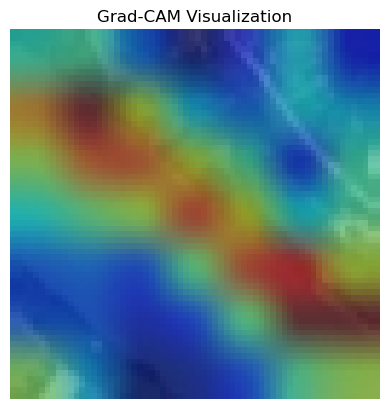

In [215]:
# Load the model from the checkpoint
checkpoint_path = r'C:\Users\isaac\FYPCodeLatest\model_checkpoints\final_resnet18_1.ckpt'
model.eval()

# Load an image
image_path = r"D:\Datasets\eurosat\2750\River\River_2.jpg" # Replace with the path to your image
image = Image.open(image_path).convert("RGB")
input_tensor = Config.test_transforms(image).unsqueeze(0)  # Add batch dimension

# Grad-CAM
cam_extractor = GradCAM(model.model, target_layer=model.model.layer4)

# Forward pass
logits = model(input_tensor)

# Get the index corresponding to the maximum logit score
pred_label = torch.argmax(logits, dim=1).item()

# Calculate the GradCAM heatmap
activation_map = cam_extractor(pred_label, logits)[0]

# Convert tensor to image
activation_map = activation_map.squeeze().cpu().numpy()
activation_map = np.clip(activation_map, 0, 1)  # Clip values to [0, 1]

# Apply colormap and remove alpha channel
heatmap = plt.cm.jet(activation_map)[..., :3]  # Convert to RGB only (discard alpha channel)

# Convert heatmap to PIL image and ensure it's RGB
heatmap = Image.fromarray((heatmap * 255).astype(np.uint8)).convert("RGB").resize(image.size)

# Convert images to numpy arrays for overlay
image_np = np.array(image)
heatmap_np = np.array(heatmap)

# Blend images with alpha
alpha = 0.5  # Transparency factor
result_np = (alpha * image_np + (1 - alpha) * heatmap_np).astype(np.uint8)

# Convert result back to PIL for display
result = Image.fromarray(result_np)

# Display the result
plt.imshow(result)
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()